## Table of Contents
* [Load S3 image](#Load-S3-image)
* [Show ratio1 band](#Show-ratio1-band)
* [Load the model and make predictions on the S3 image](#Load-the-model-and-make-predictions-on-the-S3-image)
* [Make standard deviation preds with GPR model](#Make-standard-deviation-preds-with-GPR-model)
* [Save preds to `envi`](#Save-preds-to-envi)

In [11]:
from ml import cdom_processing
from ml.cdom_processing import load_S3_image_C2RCC
from ml import data_load_SYKE_S3
from ml import models
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from imp import reload
import warnings
warnings.filterwarnings("ignore")

## Load S3 image 
[Table of Contents](#Table-of-Contents)

In [2]:
##Read the images from the S3Images folder (include whole path with directory)
s3image_path = "/Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/S3Images/subset_0_of_S3B_OL_1_EFR____20220518T092327_20220518T092627_20220518T210852_0179_066_093_1980_PS2_O_NT_002_C2RCC.data"
img = cdom_processing.load_S3_image_C2RCC(image_path=s3image_path)
img.shape

(1857, 1825, 18)

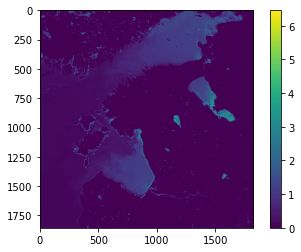

In [3]:
##Plot the image to check that it was read properly
plt.imshow(img[:,:,17])
plt.colorbar()
plt.show()

## Load and show water mask
[Table of Contents](#Table-of-Contents)

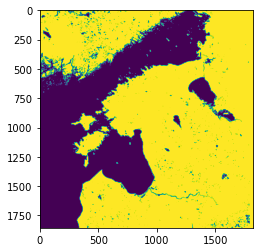

In [4]:
##Load the mask using the function 'cdom_processing.load_mask_C2RCC'
reload(cdom_processing)
mascara = cdom_processing.load_mask_C2RCC(s3image_path)
mascara = (mascara==1)
plt.imshow(mascara)
plt.show()

## Show ratio1 band
[Table of Contents](#Table-of-Contents)

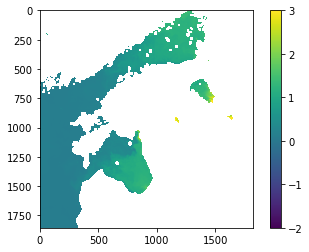

In [5]:
## Show one specific band (ratio1 in the example) with the mask on
ratio = np.ma.masked_array(img[:,:,17],mascara)
plt.imshow(ratio,vmin=-2,vmax=3)
plt.colorbar()
plt.show()
plt.close()

## Load the model and make predictions on the S3 image
[Table of Contents](#Table-of-Contents)

In [22]:
# Load one of the models stored in the 'models' folder; you need to give the complete name (band combiantion)
name_model = "RFR"
bands_name = "S3bands&ratios"

def load_model(name_model,bands_name):
    file_model = os.path.join(data_load_SYKE_S3.PATH_TO_MODELS_SYKE,
                              name_model+'_'+bands_name+'.pkl')
    return joblib.load(file_model)

regressor_sklearn = load_model(name_model,bands_name)
regressor_sklearn

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [23]:
# Select the image to predict. band names of model and image should be the same or be correspondent
reload(cdom_processing) 
image_predict = cdom_processing.image_to_predict_S3_C2RCC(img,data_load_SYKE_S3.bands_try_SYKE[bands_name])
image_predict.shape

(1857, 1825, 14)

In [24]:
#Optiional: number of pixels that are masked
np.sum(mascara)

2239204

In [25]:
# Load training data to add the mean and compute the min,max range of the predicted variable
_, _, skdata_y_train, _ = data_load_SYKE_S3.load_SYKE()


mean_y_train = np.mean(skdata_y_train)
max_cdom = np.max(skdata_y_train)
predictions = cdom_processing.predict_image(image_predict,
                                            mascara,
                                            regressor_sklearn,
                                            y_range=(0,max_cdom),
                                            y_mean=mean_y_train,step=300)
                                            
                                            
predictions.shape


(1857, 1825)

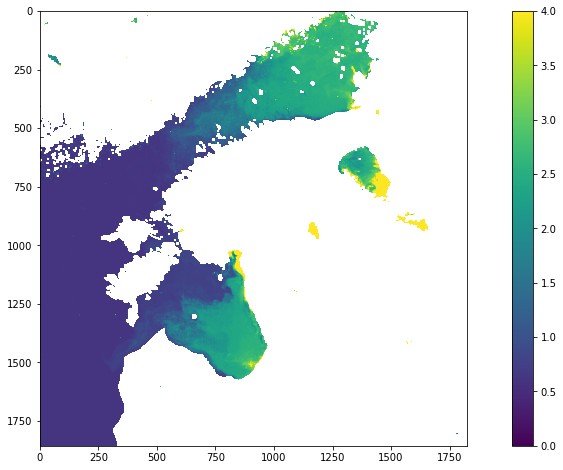

In [26]:
#Show the results of the prediction
plt.figure(figsize=(16,8))
plt.imshow(predictions,vmin=0,vmax=4)
plt.colorbar()
plt.show()

## Save preds to `envi`
[Table of Contents](#Table-of-Contents)

In [22]:
#Save image in envi format (hdr, img) to be opened in SNAP
folder_save = "."
cdom_processing.write_envi(predictions, os.path.join(folder_save,
                                                     name_model+'_'+bands_name+'_CDOM_20220518_C2RCC.hdr'))
                           
